# Self-Driving Car Engineer Nanodegree
## Computer Vision
## Problem 4: Advanced Line Finding


The goals / steps of this project are the following:

>* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

### Camera Calibration and Distortion Correction

Image distortion occurs when a camera looks at 3D objects in the real world and transforms them into a 2D image; this transformation isn’t perfect. Distortion actually changes what the shape and size of these 3D objects appear to be. So, the first step in analyzing camera images, is to undo this distortion so that you can get correct and useful information out of them.

In [1]:
import lane_finding_images as lf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from lane_finding_images import test_corners
%matplotlib inline

In [2]:
#read file names for calibration images
fnames = glob.glob('camera_cal/calibration*.jpg')

In [3]:
# Arrays to store object points and image points from all the images.
objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane.

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2) # x, y coordinates

In [4]:
for fname in fnames:
    #convert image to grayscale
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)


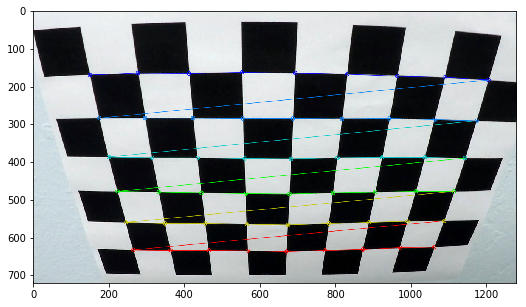

In [5]:
#Corners Visualization
plt.figure(figsize=(10,5))
plt.imshow(test_corners(fnames[11]))

In [6]:
# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[:2][::-1],None,None)


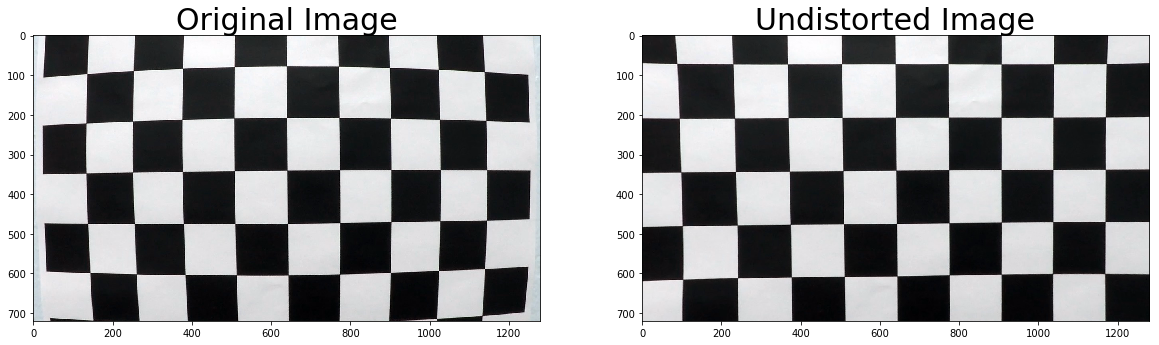

In [7]:
# Undistortion testing on chessboard
img = cv2.imread('camera_cal/calibration1.jpg')
undist = cv2.undistort(img, mtx, dist, None, mtx)

#plot results
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=30)

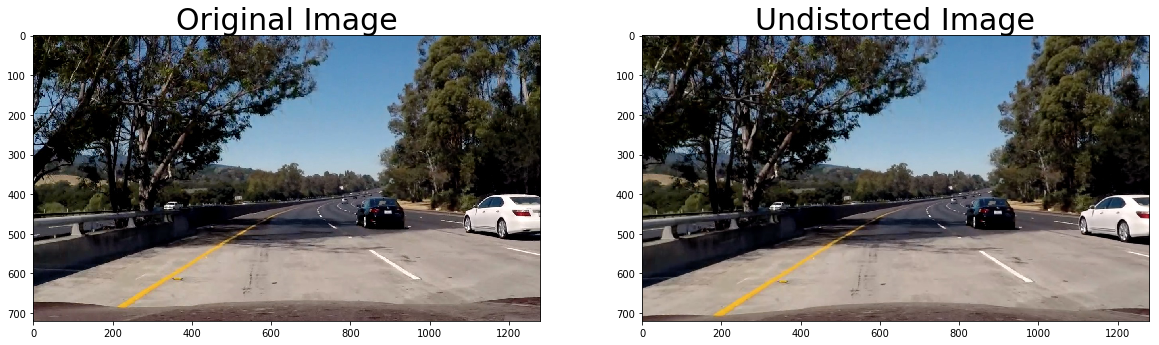

In [8]:
# Undistortion testing on road image
img = mpimg.imread('test_images/test5.jpg')
undist = cv2.undistort(img, mtx, dist, None, mtx)

#plot results
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=30)

### Color and Gradient Filtering

Here I combine various gradient and colorspace filters, to isolate the lane lines.

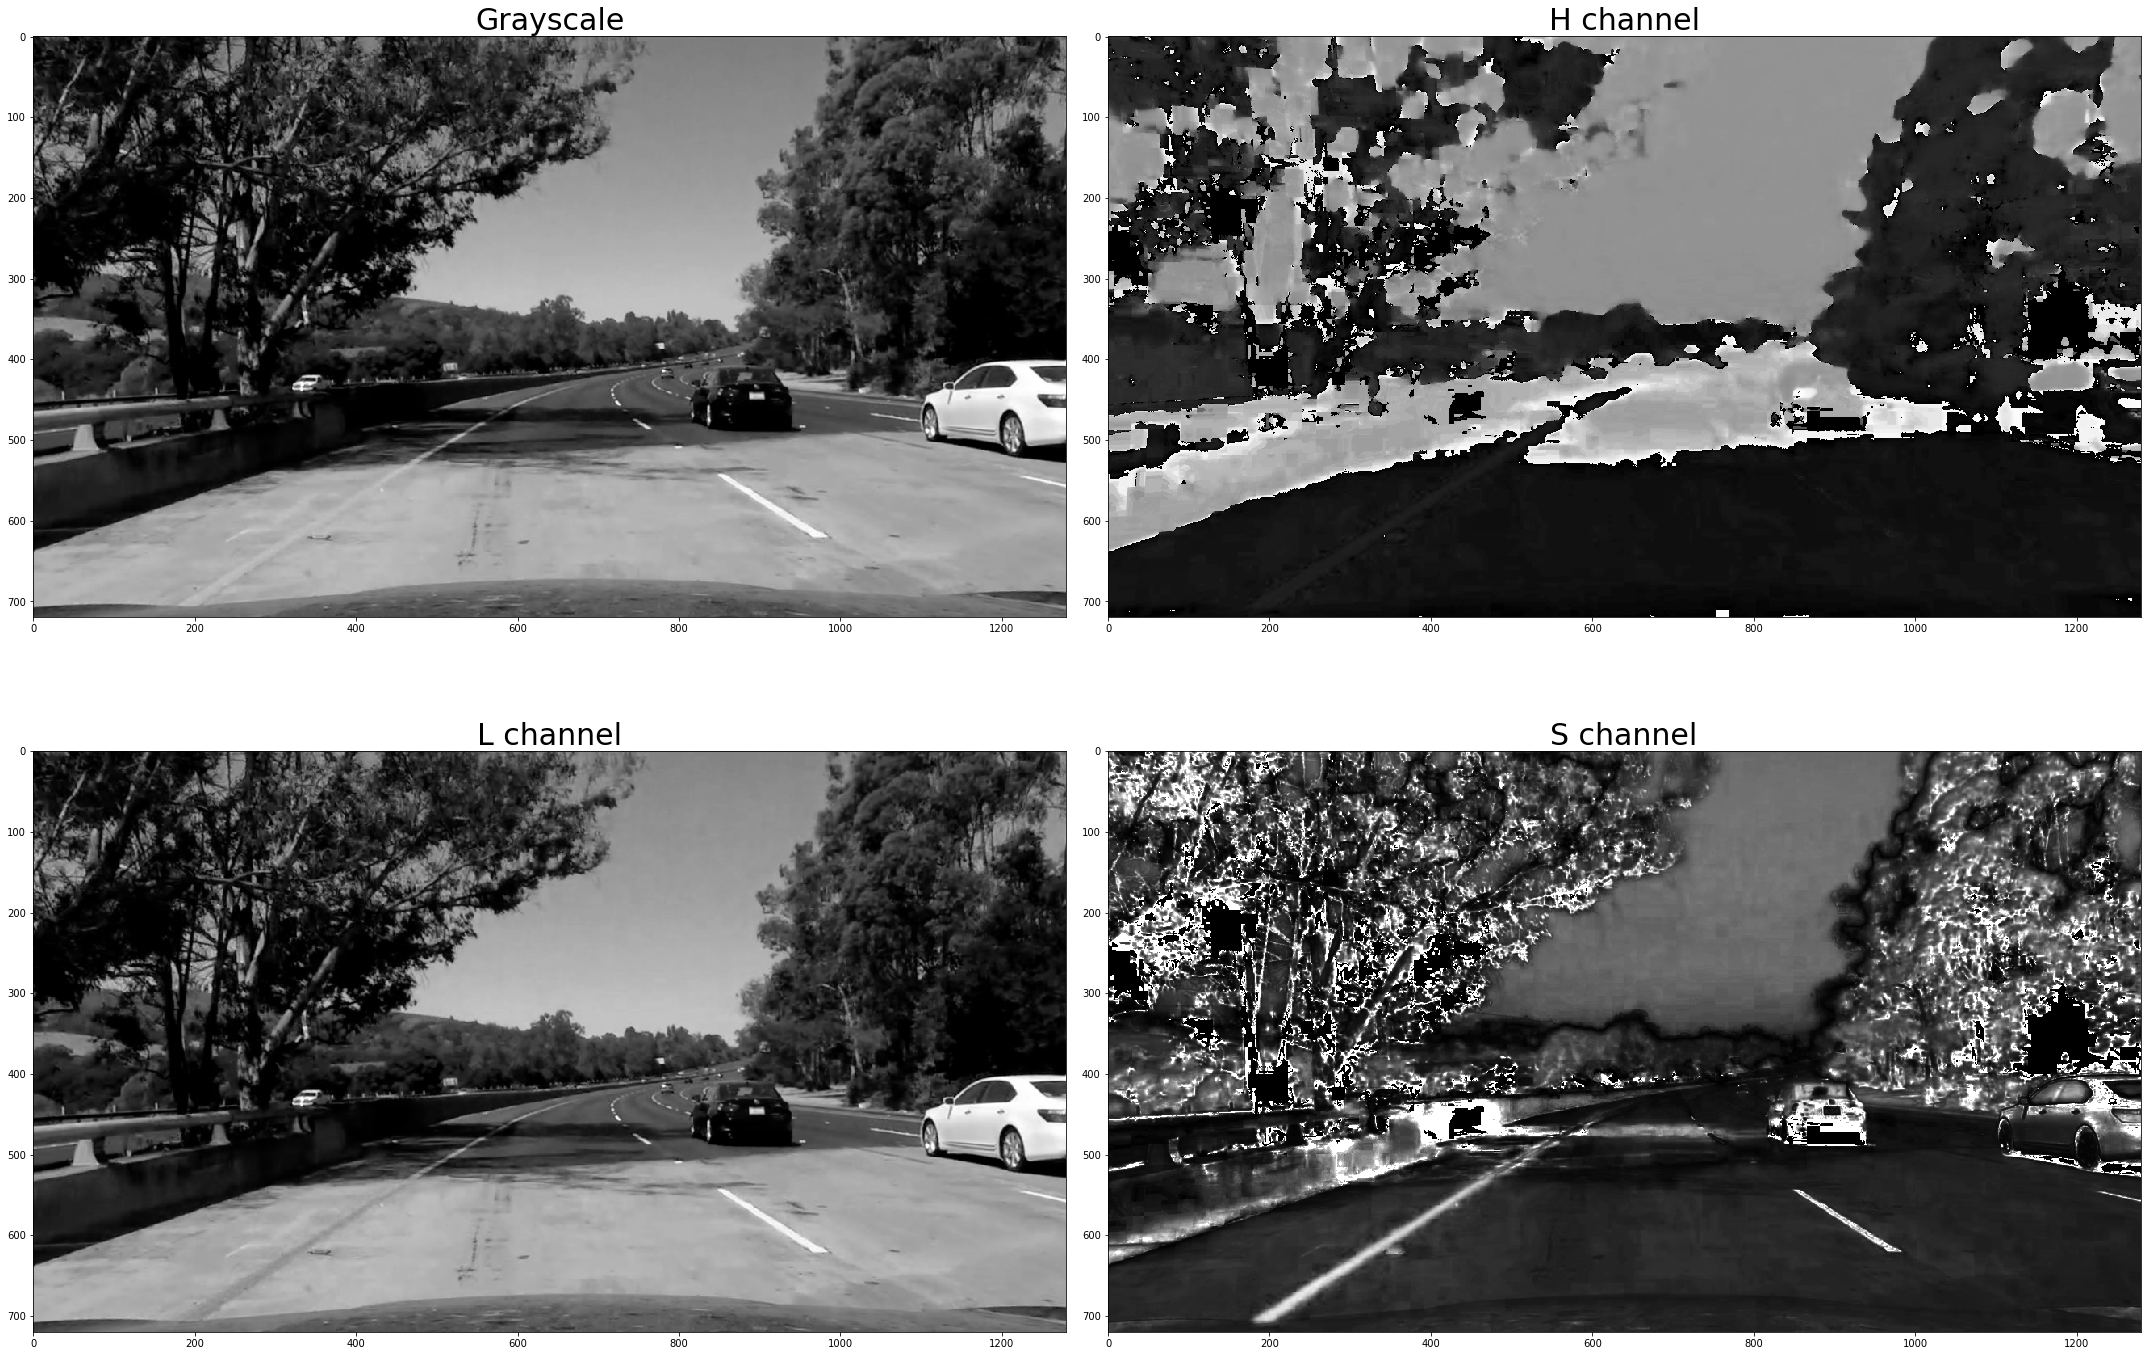

In [9]:
#Shadow Masking
import lane_finding_images as lf
import glob

#read file names for test images
fnames = glob.glob('test_images/test*.jpg')
fname = fnames[4]
img = mpimg.imread(fname)
img = cv2.undistort(img, mtx, dist, None, mtx)

gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

s_channel = hls[:,:,2]
l_channel = hls[:,:,1]
h_channel = hls[:,:,0]

#Grayscale Thresholds for shadows
shw_mask = np.ones_like(gray)
shw_mask[(gray >= 0) & (gray <= 55)] = 0

#Visualize color space
f, ([ax1, ax2], [ax3, ax4]) = plt.subplots(2, 2, figsize=(30, 20))
f.tight_layout()
ax1.imshow(gray, cmap='gray')
ax1.set_title('Grayscale', fontsize=30)
ax2.imshow(h_channel, cmap='gray')
ax2.set_title('H channel', fontsize=30)
ax3.imshow(l_channel, cmap='gray')
ax3.set_title('L channel', fontsize=30)
ax4.imshow(s_channel, cmap='gray')
ax4.set_title('S channel', fontsize=30)


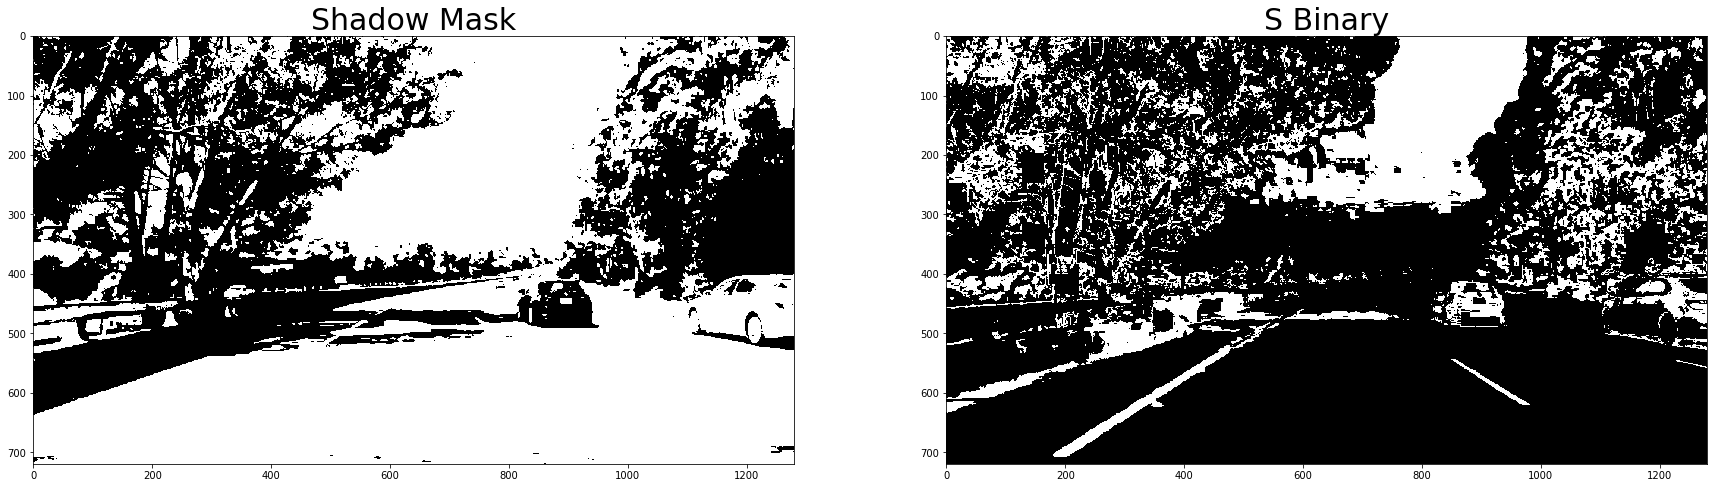

In [10]:

import lane_finding_images as lf

#Creating S Binary
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
s_channel = hls[:,:,2]
s_binary = lf.s_channel_thresh(img,100,255)

# Plot the result
f, (ax1,ax2) = plt.subplots(1,2,figsize=(30, 20))
ax1.imshow(shw_mask, cmap='gray')
ax1.set_title('Shadow Mask', fontsize=30)
ax2.imshow(s_binary, cmap='gray')
ax2.set_title('S Binary', fontsize=30)

#Applying mask on S
masked_binary = np.zeros_like(s_binary)
masked_binary[(shw_mask == 1) & (s_binary == 1)] = 1

color = masked_binary

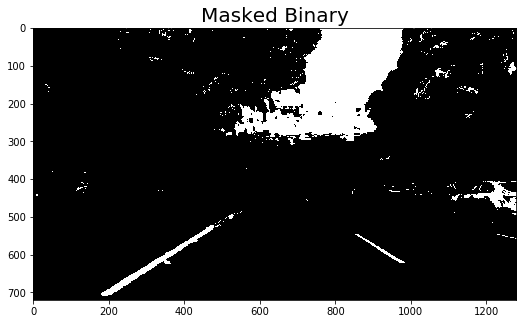

In [11]:
# Show masking result
f, ax1 = plt.subplots(1,1,figsize=(20, 5))
ax1.imshow(masked_binary, cmap='gray')
ax1.set_title('Masked Binary', fontsize=20)

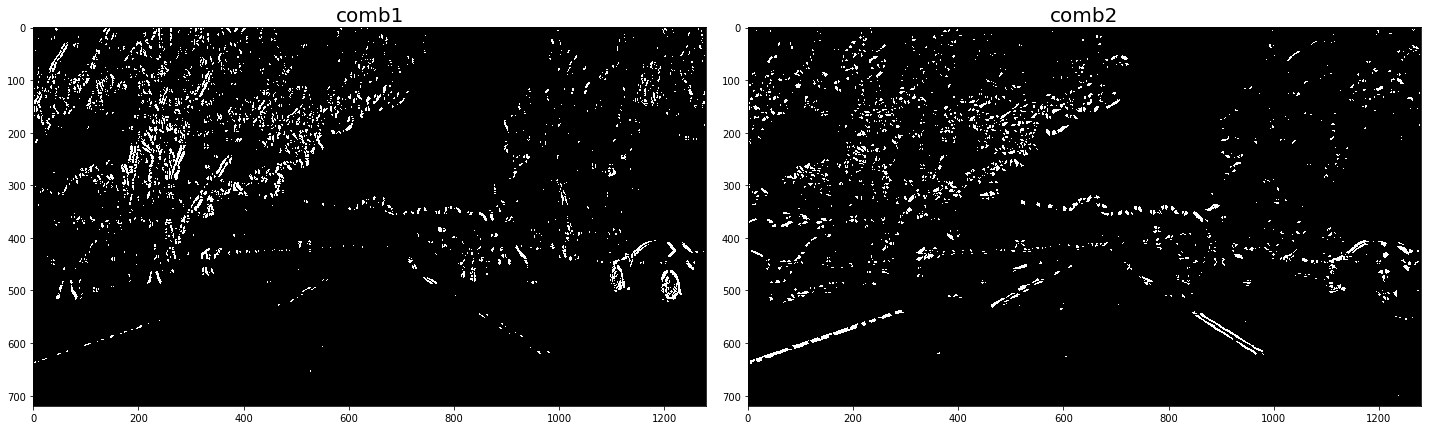

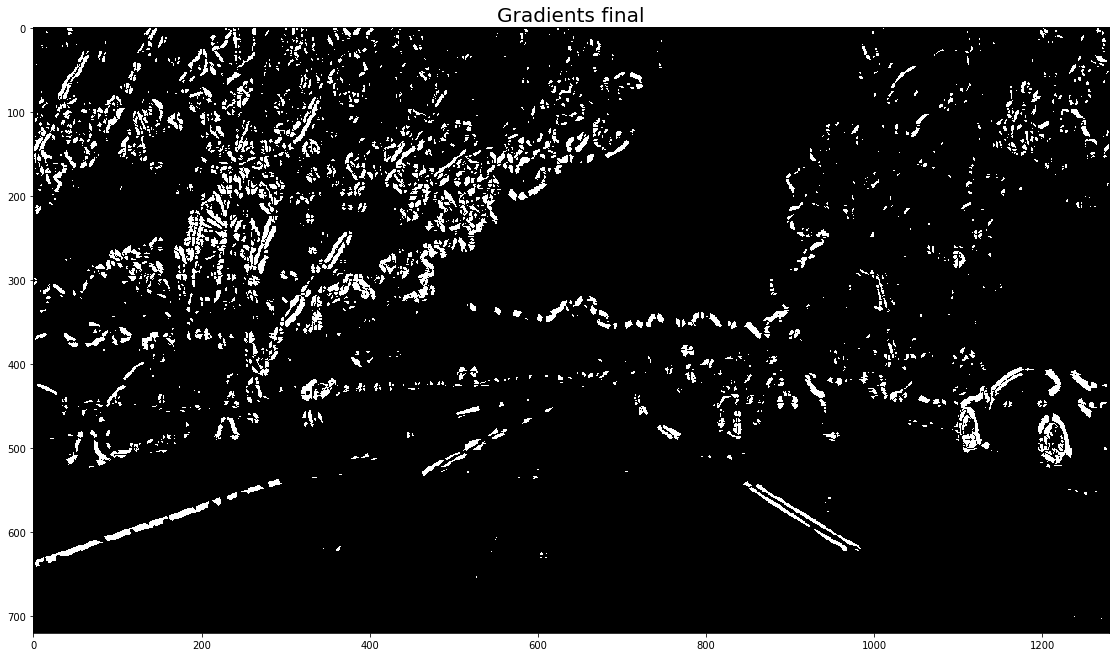

In [12]:
#Visualize Gradient binaries

import lane_finding_images as lf

img = mpimg.imread(fname)
img = cv2.undistort(img, mtx, dist, None, mtx)

#Run gradients
grady = lf.abs_sobel_thresh(img, orient='y',kernel=13, thresh_min=10, thresh_max=255)
gradx = lf.abs_sobel_thresh(img, orient='x',kernel=13, thresh_min=50, thresh_max=255)
mag_binary = lf.mag_thresh(img, sobel_kernel=21, mag_thresh=(50, 255))
dir_binary = lf.dir_threshold(img, sobel_kernel=31, thresh=(0.7, 1.3))

#comb = gradx
comb1 = np.zeros_like(grady)
comb1[((gradx == 1) & (grady == 1))] = 1

comb2 = np.zeros_like(grady)
comb2[((dir_binary ==1) & (mag_binary ==1 ))] = 1

result = np.zeros_like(grady)
result[((gradx == 1) & (grady == 1) )|( (dir_binary ==1) & mag_binary ==1)] = 1
grads = result

# Plot the result
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(20, 9))
f.tight_layout()
ax1.imshow(comb1, cmap='gray')
ax1.set_title('comb1', fontsize=20)
ax2.imshow(comb2, cmap='gray')
ax2.set_title('comb2', fontsize=20)

# Plot the result
f, ax1 = plt.subplots(1, 1, figsize=(20, 9))
f.tight_layout()

ax1.imshow(result, cmap='gray')
ax1.set_title('Gradients final', fontsize=20)

In [13]:
import lane_finding_images as lf
#stack binaries
color_binary = np.dstack(( np.zeros_like(color), color, grads)) * 255
img = color_binary
vertices = np.array([[(100,img.shape[0]),(550, 450), (img.shape[1]-550, 450), (img.shape[1]-100,img.shape[0])]], dtype=np.int32)
color_binary = lf.region_of_interest(color_binary,vertices)

# Combine the two binary thresholds
combined_binary = np.zeros_like(color)
combined_binary[(color == 1) | (grads == 1)] = 1
#combined_binary = lf.region_of_interest(combined_binary,vertices)

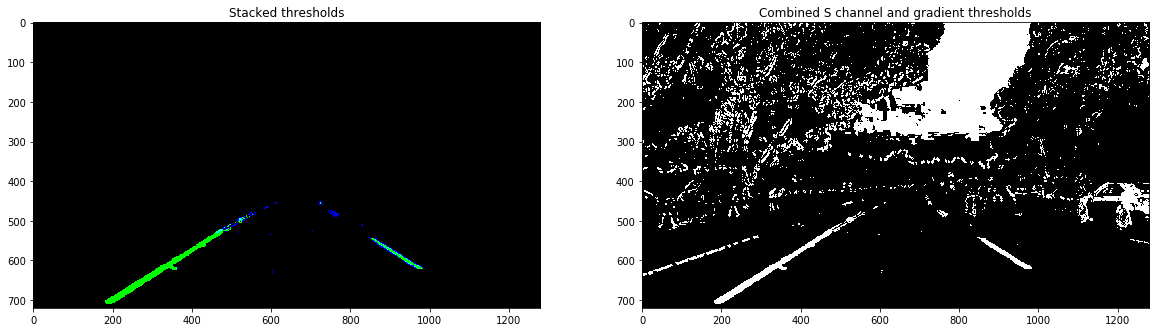

In [14]:

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')


### Perspective Transform

A perspective transform maps the points in a given image to different, desired, image points with a new perspective. The perspective transform you’ll be most interested in is a bird’s-eye view transform that let’s us view a lane from above; this will be useful for calculating the lane curvature later on. Aside from creating a bird’s eye view representation of an image, a perspective transform can also be used for all kinds of different view points.

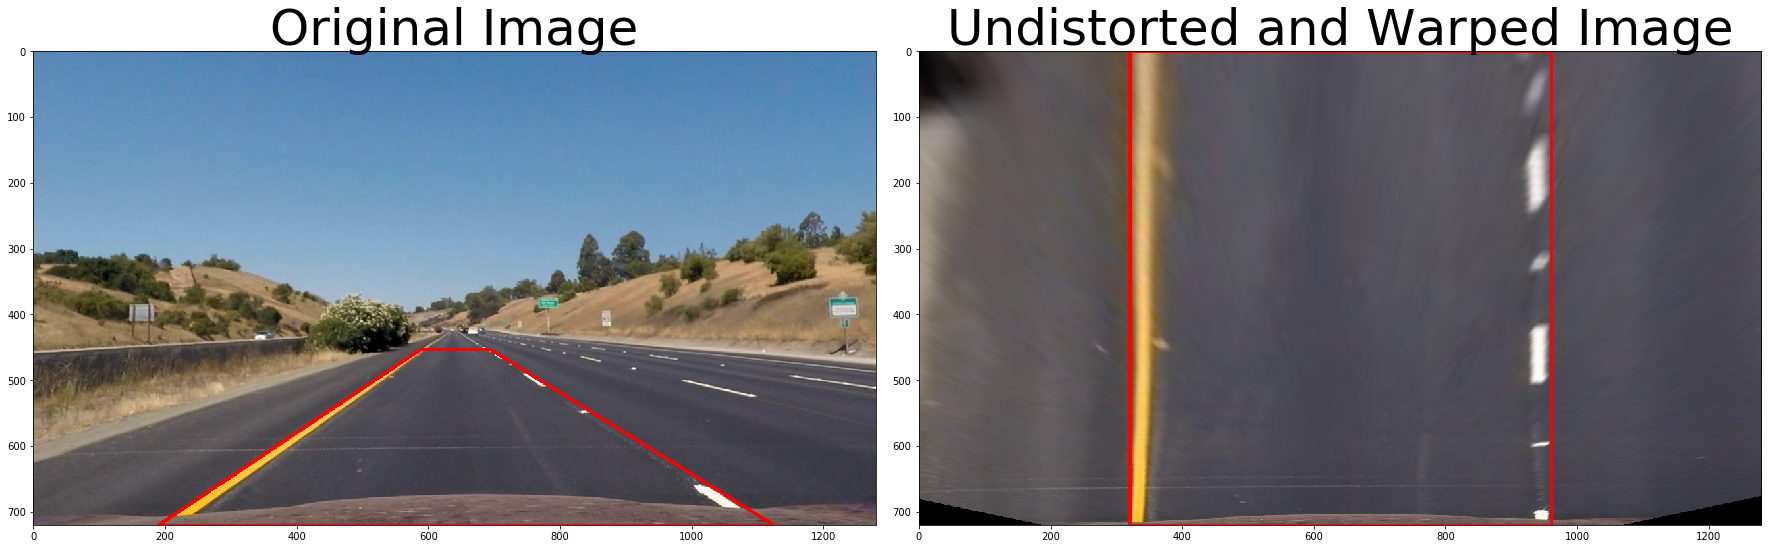

In [15]:
#--------------------------------
# Perspective Transform Pipeline
#--------------------------------

from lane_finding_images import lane_warp

#read the image of the road with the straight lines
img = mpimg.imread("test_images/straight_lines1.jpg")
img = cv2.undistort(img, mtx, dist, None, mtx)

#do the perspective transform 
top_down, src_pts, dst_pts, _ = lane_warp(img)

#draw red line overlays
cv2.polylines(img, [src_pts], isClosed=True, color=(255,0,0),thickness=3)
cv2.polylines(top_down, [dst_pts], isClosed=True, color=(255,0,0),thickness=3)

#plot figures
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

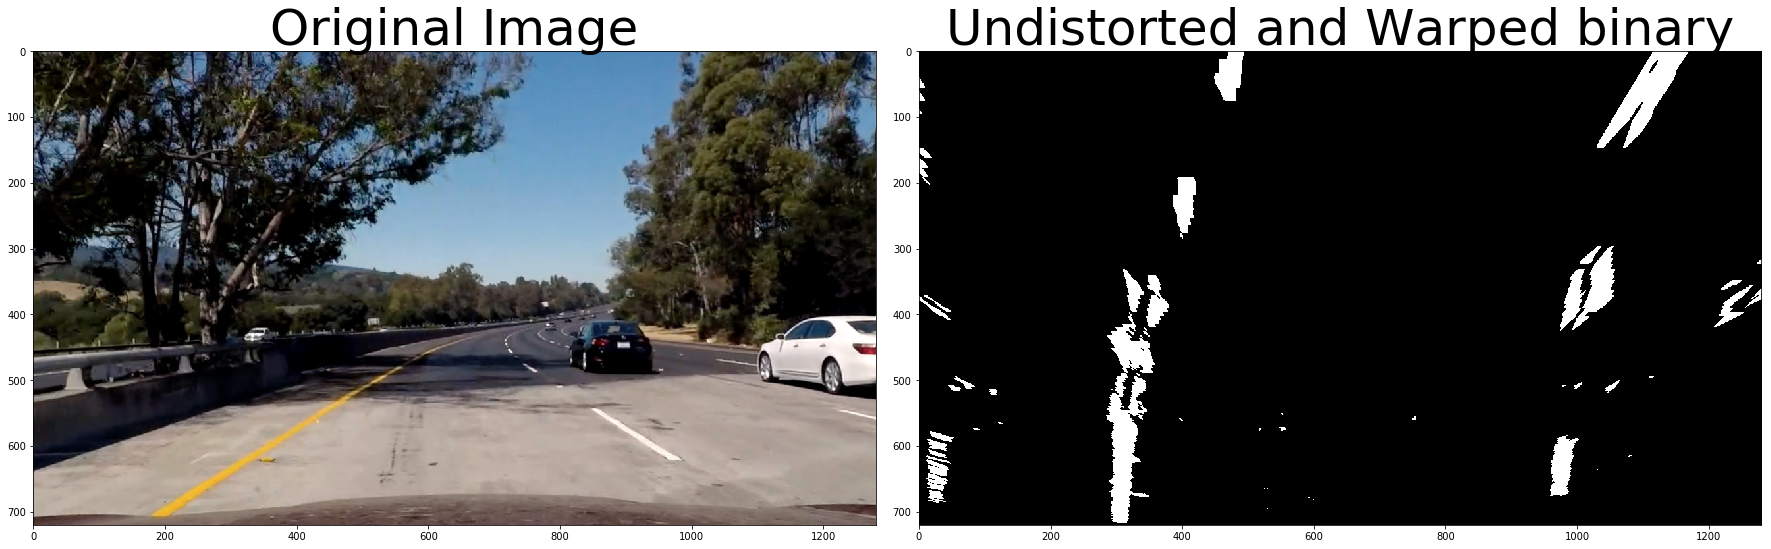

In [16]:

#Testing perspective transform on binary image

img = mpimg.imread(fname)
img = cv2.undistort(img, mtx, dist, None, mtx)

#do the perspective transform 
top_down, src_pts, dst_pts, Minv = lane_warp(combined_binary)

#plot figures
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down, cmap='gray')
ax2.set_title('Undistorted and Warped binary', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



### Lane Finding

Below is a lane detection pipeline. It uses a histogram to search for the lines base points and then applies a sliding windows algorithm to find pixels and plot a quadratic line.

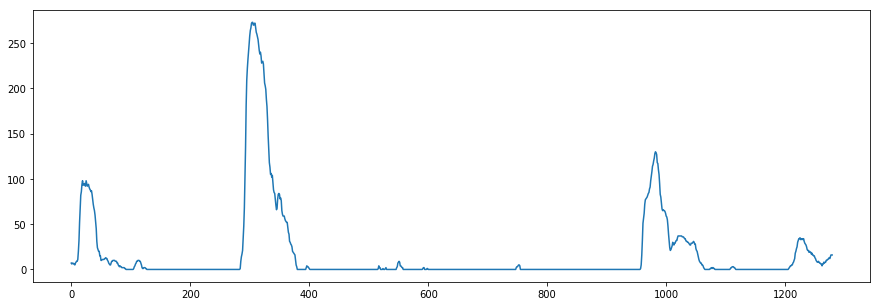

In [17]:
img = top_down
histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
plt.figure(figsize=(15,5))
plt.plot(histogram)

(720, 0)

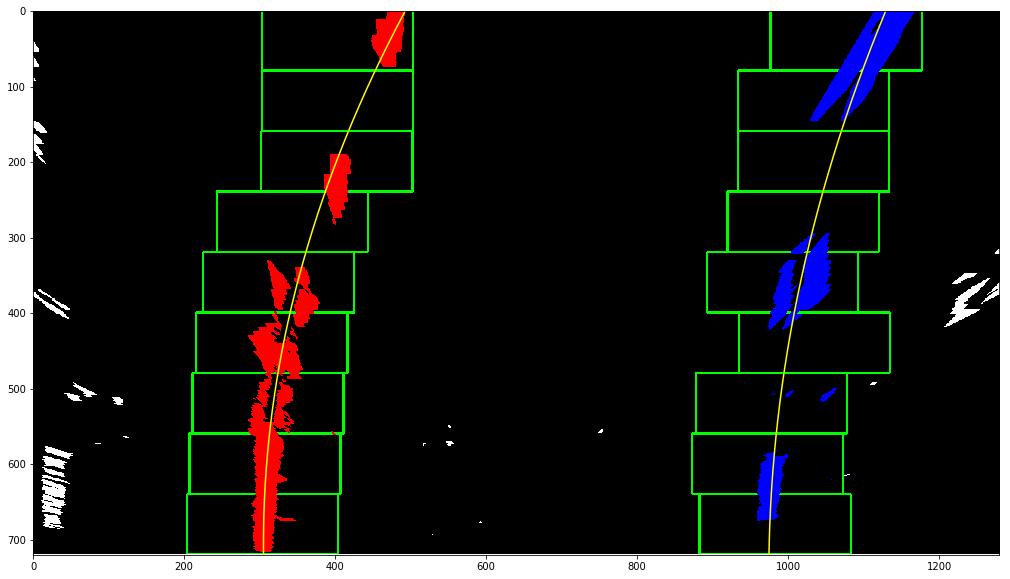

In [18]:
from lane_finding_images import lane_find

left_fitx, right_fitx, left_lane_inds, right_lane_inds, out_img, ploty,_,_= lane_find(img)

plt.figure(figsize=(20,10))
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

(720, 0)

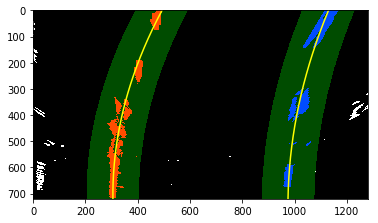

In [19]:
from lane_finding_images import draw_lanes
result = draw_lanes(img,left_lane_inds, right_lane_inds,left_fitx, right_fitx,ploty)

plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

### Image pipeline with Curvature and Offset Calculation

Here is a working pipeline to identify lane lines from an image. I made some functions to calculate the average radius of the lane and the offset of the vehicle from the lane center.


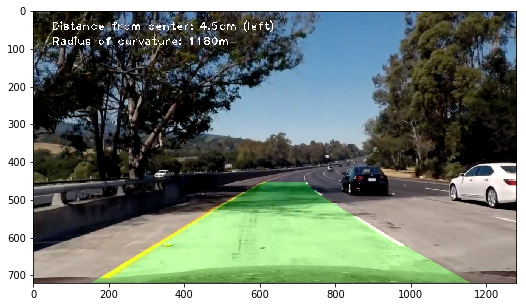

In [20]:
import lane_finding_images as lf
import numpy as np
import cv2
import matplotlib.pyplot as plt

def process_image(image):
    
    image = cv2.undistort(image, mtx, dist, None, mtx)
    #Run gradients
    grady = lf.abs_sobel_thresh(image, orient='y',kernel=7, thresh_min=50, thresh_max=130)
    gradx = lf.abs_sobel_thresh(image, orient='x',kernel=7, thresh_min=20, thresh_max=130)
    comb1 = np.zeros_like(grady)
    comb1[((gradx == 1) & (grady == 1))] = 1
    
    s_channel = lf.s_channel_thresh(image) 
    dir_binary = lf.dir_threshold(image, sobel_kernel=31, thresh=(0.7, 1.3))
    comb2 = np.zeros_like(s_channel)
    comb2[((dir_binary == 1) & (s_channel == 1))] = 1
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(comb1)
    combined_binary[(comb1 == 1) | (comb2 == 1)] = 1
    
    vertices = np.array([[(100,image.shape[0]),(550, 450), (image.shape[1]-550, 450), (image.shape[1]-100,image.shape[0])]],dtype=np.int32)
    combined_binary = lf.region_of_interest(combined_binary,vertices)
    
    img,_,_,Minv = lf.lane_warp(combined_binary)

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    left_fitx, right_fitx, _, _, _, ploty, leftx_base, rightx_base = lf.lane_find(img)
   
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 

    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    left_curverad, right_curverad= lf.radius(ploty, left_fitx, right_fitx)
    off_center = lf.center_offset(leftx_base,rightx_base)
    
    #Draw text on image
    font = cv2.FONT_HERSHEY_PLAIN
    if off_center > 0:
        str1 = str('Distance from center: '+str(round(abs(off_center)*100,1))+'cm (right)')
    else:
        str1 = str('Distance from center: '+str(round(abs(off_center)*100,1))+'cm (left)')
    cv2.putText(result,str1,(50,50), font, 2,(255,255,255),2)
    
    if left_curverad and right_curverad:
        curvature = np.int(0.5*right_curverad + left_curverad)
        str2 = str('Radius of curvature: '+str(curvature)+'m')
        cv2.putText(result,str2,(50,90), font, 2,(255,255,255),2)        
    return result


image = mpimg.imread(fname)

result = process_image(image)
plt.figure(figsize=(10,5))
plt.imshow(result)

### Video Pipeline

Below is the pipeline I used to find the lane on a video stream. It uses all the features described so far and is also able to detect bad frames and skip them.

In [21]:
import numpy as np
import cv2
import matplotlib as plt
import lane_finding_video as lf
from lane_finding_video import lane

def process_image(image):  
    
    img = cv2.undistort(image, mtx, dist, None, mtx)
    
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    #Grayscale Thresholds for shadows
    shw_mask = np.ones_like(gray)
    shw_mask[(gray >= 0) & (gray <= 55)] = 0
    
    s_channel = hls[:,:,2]
    s_binary = lf.s_channel_thresh(img,100,255)
    
    #Applying mask on S
    masked_binary = np.zeros_like(s_binary)
    masked_binary[(shw_mask == 1) & (s_binary == 1)] = 1
    
    #Run gradients
    grady = lf.abs_sobel_thresh(img, orient='y',kernel=13, thresh_min=10, thresh_max=255)
    gradx = lf.abs_sobel_thresh(img, orient='x',kernel=13, thresh_min=50, thresh_max=255)
    mag_binary = lf.mag_thresh(img, sobel_kernel=21, mag_thresh=(50, 255))
    dir_binary = lf.dir_threshold(img, sobel_kernel=31, thresh=(0.7, 1.3))

    #combine gradients
    comb = np.zeros_like(grady)
    comb[((gradx == 1) & (grady == 1) )|( (dir_binary ==1) & mag_binary ==1)] = 1
        
    grads = comb
    color = masked_binary
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(color)
    combined_binary[(color == 1) | (grads == 1)] = 1
    
    # Apply ROI
    vertices = np.array([[(100,img.shape[0]),(550, 450),(img.shape[1]-550, 450),(img.shape[1]-100,img.shape[0])]], dtype=np.int32)
    combined_binary = lf.region_of_interest(combined_binary,vertices)
    
    img,_,_,Minv = lf.lane_warp(combined_binary)

    # Find lane lines
    lane.find_lines(img)
    
    # Create blank images to draw on
    warp_zero = np.zeros_like(img).astype(np.uint8)
    pixels = np.dstack((warp_zero, warp_zero, warp_zero))
    green_overlay = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Draw green lane overlay
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    pts_left = np.array([np.transpose(np.vstack([lane.left.bestx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([lane.right.bestx, ploty])))])
    pts = np.hstack((pts_left, pts_right))   
    cv2.fillPoly(green_overlay, np.int_([pts]), (0,255, 0))
    
    # Draw detected pixels
    pixels[lane.left.ally, lane.left.allx] = [255, 0, 0]
    pixels[lane.right.ally, lane.right.allx] = [0, 0, 255]
    
    # Warp the images back to original image space using inverse perspective matrix (Minv)
    pixels = cv2.warpPerspective(pixels, Minv, (image.shape[1], image.shape[0])) 
    green_overlay = cv2.warpPerspective(green_overlay, Minv, (image.shape[1], image.shape[0]))
    
    # Combine them with the original image
    result = cv2.addWeighted(image, 1, green_overlay, 0.3, 0)
    result = cv2.addWeighted(result, 0.7, pixels, 1.5, 0)
    
    # Calculate curvature and offset
    left_curverad, right_curverad= lf.radius(ploty, lane.left.bestx, lane.right.bestx)
    off_center = lf.center_offset(lane.left.line_base_pos, lane.right.line_base_pos)
    
    #Draw text on image
    font = cv2.FONT_HERSHEY_PLAIN
    if off_center > 0:
        str1 = str('Distance from center: '+str(round(abs(off_center)*100,1))+'cm (right)')
    else:
        str1 = str('Distance from center: '+str(round(abs(off_center)*100,1))+'cm (left)')
    cv2.putText(result,str1,(50,50), font, 2,(255,255,255),2)
    
    if left_curverad and right_curverad:
        curvature = np.int(0.5*right_curverad + left_curverad)
        str2 = str('Radius of curvature: '+str(curvature)+'m')
        cv2.putText(result,str2,(50,90), font, 2,(255,255,255),2)   
    
    return result


In [22]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


white_output = 'final_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("project_video.mp4").subclip(28,30)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video final_video.mp4
[MoviePy] Writing video final_video.mp4


100%|█████████████████████████████████████▉| 1260/1261 [09:15<00:00,  2.32it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: final_video.mp4 

Wall time: 9min 17s


In [23]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))